In [ ]:
import tensorflow as tf

from google.colab import drive

import cv2

from glob import glob
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output
import matplotlib.pyplot as plt

from sklearn import metrics as skm
import random

from tensorflow.python.ops import math_ops

SIZE = 1024


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Segmentation/Images/split16

'Test - Images'  'Test - Masks'  'Training - Images'  'Training - Masks'


7


<Figure size 1440x1440 with 0 Axes>

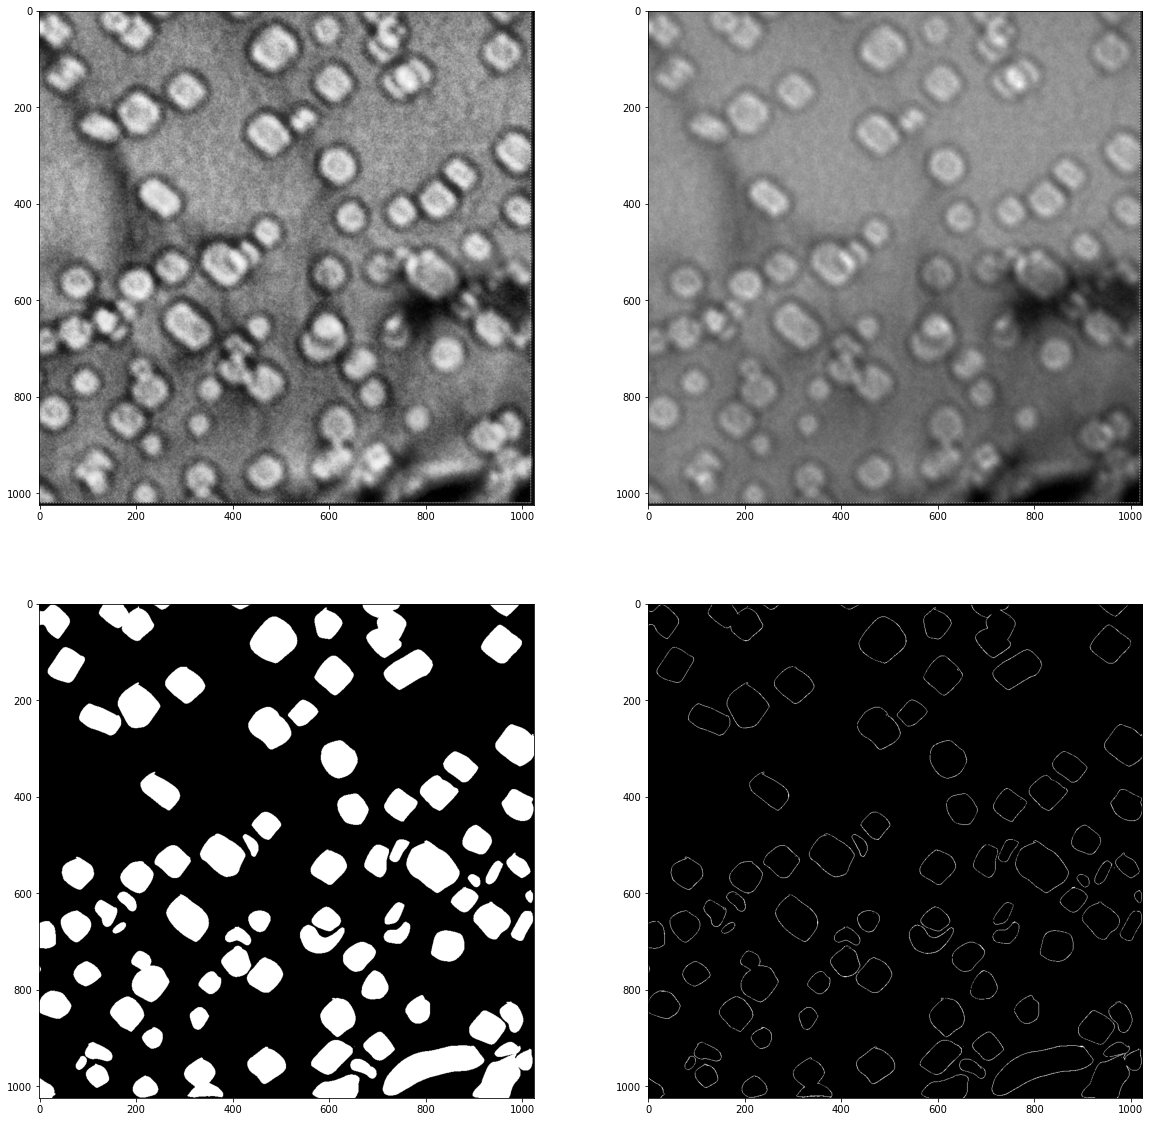

In [ ]:
def load_image_paths(dir = '/content/drive/MyDrive/Segmentation/Images/split16'):
  dirs = (os.path.join(dir, 'Training - Images/*.tif'),
          os.path.join(dir, 'Training - Masks/*.tif'),
          os.path.join(dir, 'Test - Images/*.tif'),
          os.path.join(dir, 'Test - Masks/*.tif'))
  return sorted(glob(dirs[0])), sorted(glob(dirs[1])), sorted(glob(dirs[2])), sorted(glob(dirs[3]))  

def load_image(path):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  x = clahe.apply(cv2.imread(path, flags=cv2.IMREAD_GRAYSCALE))
  x = np.expand_dims((x/255.0).astype(np.float32), axis=2)
  return x

def load_mask(path):
  _, mask = cv2.threshold(cv2.imread(path, flags=cv2.IMREAD_GRAYSCALE), 1, 255, cv2.THRESH_BINARY)
  return np.expand_dims((mask/255.0).astype(np.float32), axis=2)

u,v,w,x = load_image_paths()
i = random.randint(0, 15)
print(i)
x = load_image(u[i])
load_mask(v[i])
raw_image = cv2.imread(u[i])
raw_mask = cv2.imread(v[i], flags=cv2.IMREAD_GRAYSCALE)
non_binary_mask = (np.logical_and(raw_mask > 0, raw_mask < 255))*1.
plt.rcParams["figure.figsize"] = (20,20)
plt.figure()
f, axarr = plt.subplots(2, 2)
axarr[0][0].imshow(np.squeeze(x, axis=2), cmap = 'gray') 
axarr[0][1].imshow(raw_image, cmap = 'gray')
axarr[1][0].imshow(load_mask(v[i]).reshape((1024, 1024)), cmap = 'gray')
axarr[1][1].imshow(non_binary_mask.reshape((1024, 1024)), cmap = 'gray')
plt.show()

**Image Augmentation Methods**

(64, 512, 512, 1)
(64, 512, 512, 1)
20
26


<Figure size 720x720 with 0 Axes>

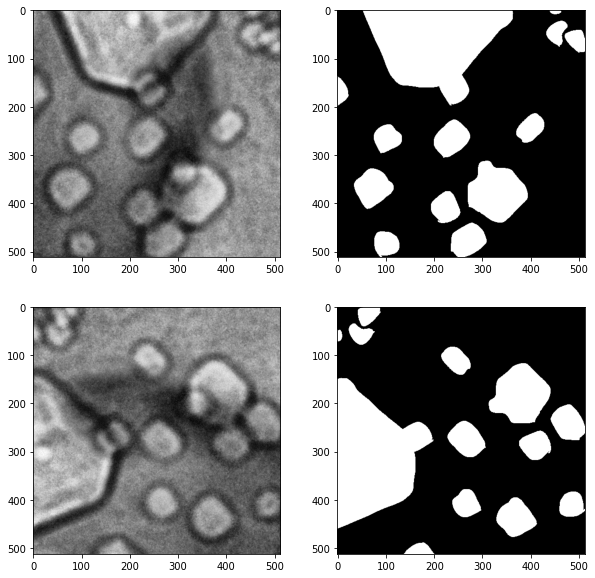

In [ ]:
def split(image):
  half = SIZE//2
  tl = image[:half, :half]
  tr = image[:half, half:]
  bl = image[half:, :half]
  br = image[half:, half:]
  return np.stack([tl, tr, bl, br]) 

## image is (None, None, 1) array
def generate_noisy_images(image, mask = False, n = 2, min = 0.0, max = 0.1):
  shape = tuple([n] + list(image.shape))
  x = np.empty(shape)
  for i in range(n):
    x[i] = image + (0 if mask else np.random.uniform(min, max, image.shape))
  return x

def rotated_and_flipped_images(image):
  img = np.squeeze(image, axis = 2)
  shape = tuple([8] + list(img.shape))
  x = np.empty(shape)
  x[0] = np.fliplr(img)
  x[1] = np.rot90(x[0])
  x[2] = np.rot90(x[1])
  x[3] = np.rot90(x[2]) 
  x[4] = np.flipud(img)
  x[5] = np.rot90(x[4])
  x[6] = np.rot90(x[5])
  x[7] = np.rot90(x[6])
  return np.expand_dims(x, axis = 3).astype(np.float32)

def rotate_and_flip_all_images(images):
  s = images.shape
  x = np.empty((s[0]*8, s[1], s[2], s[3]))
  for i in range(s[0]):
    x[8*i:8*i + 8] = rotated_and_flipped_images(images[i])
  return x.astype(np.float32);

def add_noise_to_all_images(images, n = 2, mask=False):
  s = images.shape
  x = np.empty((s[0]*n, s[1], s[2], s[3]))
  for i in range(s[0]):
    x[n*i:n*i + n] = generate_noisy_images(images[i], n = n, mask = mask)
  return x.astype(np.float32)


def augment_image(image):
  x = add_noise_to_all_images(rotate_and_flip_all_images(split(image)), mask = False).astype(np.float32)
  return x
      

def augment_mask(mask):
  x = add_noise_to_all_images(rotate_and_flip_all_images(split(mask)), mask=True).astype(np.float32)
  return x

image = load_image(u[11])
mask = load_mask(v[11])

images = augment_image(image)
masks = augment_mask(mask)

print(images.shape)
print(masks.shape)
i = np.random.randint(0, 64)
j = np.random.randint(0, 64)
print(i)
print(j)
plt.rcParams["figure.figsize"] = (10,10)
plt.figure()
f, axarr = plt.subplots(2, 2)

axarr[0][0].imshow(images[i,:,:,0], cmap = 'gray') 
axarr[0][1].imshow(masks[i,:,:,0], cmap = 'gray')
axarr[1][0].imshow(images[j,:,:,0], cmap = 'gray') 
axarr[1][1].imshow(masks[j,:,:,0], cmap = 'gray')

In [ ]:
def create_dataset(dir='/content/drive/MyDrive/Segmentation/Images/split16', batch=16):
  images, masks, _, _ = load_image_paths(dir=dir)
  seed = random.randint(0, 1000000)
  random.seed(seed)
  random.shuffle(images)
  random.seed(seed)
  random.shuffle(masks)
  def load_data(image, mask):
    def f(x,y): 
      return (augment_image(load_image(x.decode())).reshape((64, 512, 512)), augment_mask(load_mask(y.decode())).reshape((64,512*512)))
    img, msk = tf.numpy_function(f, [image, mask], [tf.float32, tf.float32])
    img.set_shape([64, 512, 512])
    msk.set_shape([64, 512*512])
    return tf.data.Dataset.from_tensor_slices((img, msk))
  return (tf.data.Dataset.from_tensor_slices((images, masks)).take(28).flat_map(load_data).shuffle(buffer_size=10000).batch(batch)
      ,tf.data.Dataset.from_tensor_slices((images, masks)).skip(28).flat_map(load_data).shuffle(buffer_size=10000).batch(batch))

def create_test_dataset(dir='/content/drive/MyDrive/Segmentation/Images/split16', batch=16):
  _, _, images, masks = load_image_paths(dir=dir)
  def load_data(image, mask):
    def f(x,y): 
      return (split(load_image(x.decode())).reshape(4, 512, 512), split(load_mask(y.decode())).reshape((4, 512*512)))
    img, msk = tf.numpy_function(f, [image, mask], [tf.float32, tf.float32])
    img.set_shape([4, 512, 512])
    msk.set_shape([4, 512*512])
    return tf.data.Dataset.from_tensor_slices((img, msk))
  return tf.data.Dataset.from_tensor_slices((images, masks)).flat_map(load_data).batch(batch)


In [ ]:
### WARNING: Do not edit. Freeze this model. This works!
def get_model(img_size=(SIZE//2, SIZE//2), num_classes=2):
    inputs = keras.Input(shape=img_size)
    filters = [4,16,32,64]
    x0 = layers.Reshape((SIZE//2, SIZE//2, 1))(inputs)
    ## x0 = layers.Dropout(0.1) (x0)

    def down_block(filters, t, dropout = 0.2):
      t1 = layers.Conv2D(filters, 3, padding="same", activation="relu") (t)
      t2 = layers.Conv2D(filters, 3, padding="same", activation="relu") (layers.concatenate([t, t1]))
      t3 = layers.MaxPooling2D(padding="valid") (layers.concatenate([t, t1, t2]))
      ## t3 = layers.Dropout(dropout)(t3)
      return t1, t2, t3

    x1, x2, x3 = down_block(4, x0) 
    x4, x5, x6 = down_block(16, x3)
    x7, x8, x9 = down_block(32, x6)

    def up_block(filters, t, dropout = 0.2):
      t1 = layers.Conv2D(filters, 3, padding="same", activation="relu") (t)
      t2 = layers.Conv2D(filters, 3, padding="same", activation="relu") (layers.concatenate([t, t1]))
      t3 = layers.Conv2DTranspose(filters//2, 2, 2, padding="valid") (layers.concatenate([t, t1, t2]))      
      ## t3 = layers.Dropout(dropout)(t3)
      return (t1, t2, t3)    

    x10, x11, x12 = up_block(64, x9)
    x13, x14, x15 = up_block(32, layers.concatenate([x6, x7, x8, x12]))
    x16, x17, x18 = up_block(16, layers.concatenate([x3, x4, x5, x15]))

    x19 = layers.Conv2D(4, 3, activation="relu", padding="same") (layers.concatenate([x0, x1, x2, x18]))
    x20 = layers.Conv2D(2, 7, activation="softmax", padding="same") (layers.concatenate([x0, x1, x2, x19]))

    y = layers.Lambda(lambda x: x[:,:,:,1]) (x20)
    y = layers.Flatten() (y)
    outputs = y
    model = keras.Model(inputs, outputs)
    return model

    # Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512)]   0           []                               
                                                                                                  
 reshape (Reshape)              (None, 512, 512, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 4)  40          ['reshape[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 512, 512, 5)  0           ['reshape[0][0]',                
                                                                  'conv2d[0][0]']             

In [ ]:
## Performance is very sensitive to loss function, optimizer and optimizer 
## learning rate
## So far iou seems to be the best.
def iou(y_true, y_pred):
  intersection = keras.backend.sum(y_true*y_pred)
  union = keras.backend.sum(y_true) + keras.backend.sum(y_pred) - intersection
  return (union-intersection)/union

##opt = tf.keras.optimizers.Adam(learning_rate=0.5)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="prec"), keras.metrics.Recall(name="rec")]
##model.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=metrics)
def schedule(epoch, lr):
  return lr*np.exp(-0.1*epoch)

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.h5", save_best_only=True),
    keras.callbacks.LearningRateScheduler(schedule)
]
# Train the model, doing validation at the end of each epoch.
epochs = 10
training_data, validation_data = create_dataset()
keras.backend.clear_session()
# model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=metrics)
saved_models =\
[
 '/content/drive/MyDrive/Segmentation/model',
 '/content/drive/MyDrive/Segmentation/segnet_100_epochs_no_dropout_no_bn_constant_lr_point0001_iou_loss_val_and_train_acc_0.95'
]

restore = False
if restore:
  model = tf.keras.models.load_model(saved_models[1], custom_objects = {'iou': iou})
else:
  model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), loss=iou, metrics=metrics)
model.fit(training_data, validation_data=validation_data, epochs=epochs, callbacks = callbacks)
model.save('/content/drive/MyDrive/Segmentation/segnet_more_than_100_epochs_no_dropout_no_bn_constant_lr_point0001_iou_loss_val_and_train_acc_0.95')

Epoch 1/10


In [ ]:
model.save("/content/drive/MyDrive/Segmentation/segnet_100_epochs_no_dropout_no_bn_constant_lr_point0001_iou_loss_val_and_train_acc_0.95")
##i = random.randint(0,15)
##print(i)
## keras.backend.clear_session()

i = 2
_, _, test_images, test_masks = load_image_paths()
x = split(load_image(test_images[i]))
y = split(load_mask(test_masks[i]))
print(x.shape)
print(y.shape)
## yy = model.predict(x).reshape((4,512,512))
yy = model.predict(x)



INFO:tensorflow:Assets written to: /content/drive/MyDrive/Segmentation/segnet_100_epochs_no_dropout_no_bn_constant_lr_point0001_iou_loss_val_and_train_acc_0.95/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Segmentation/segnet_100_epochs_no_dropout_no_bn_constant_lr_point0001_iou_loss_val_and_train_acc_0.95/assets


(4, 512, 512, 1)
(4, 512, 512, 1)


In [ ]:

eval = model.evaluate(x = create_test_dataset(), return_dict=True)
print(eval)

4/4 [==============================] - 38s 10s/step - loss: 0.6819 - acc: 0.9181 - auc: 0.6802 - prec: 0.7953 - rec: 0.3483
{'loss': 0.6819329857826233, 'acc': 0.9180920720100403, 'auc': 0.6801912188529968, 'prec': 0.7952645421028137, 'rec': 0.348253071308136}


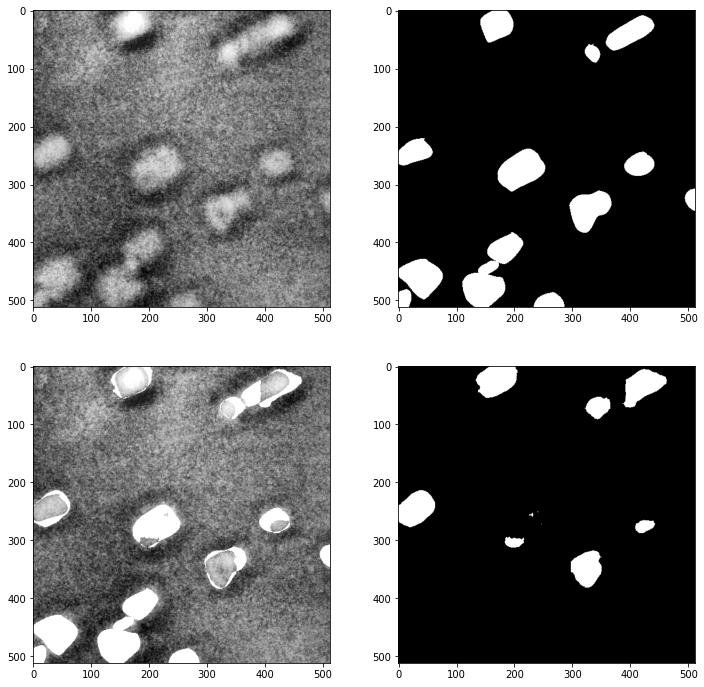

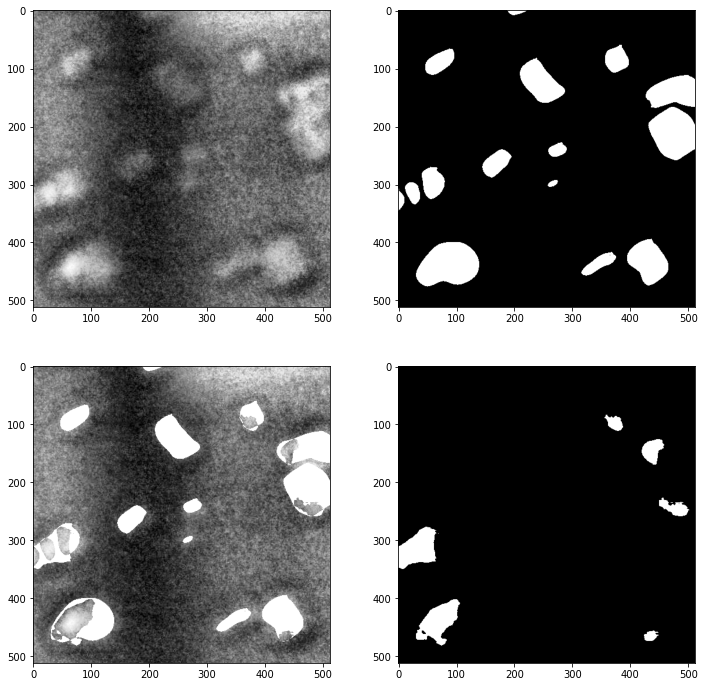

0.8995094299316406

In [ ]:
def plot_prediction(image, mask, prediction, i = 0, threshold=0.1):
  prediction = prediction[i].reshape((512, 512))
  image = image[i].reshape((512, 512))
  mask = mask[i].reshape((512, 512))
  plt.rcParams["figure.figsize"] = (12,12)
  f, a = plt.subplots(2,2)
  a[0][0].imshow(image, cmap='gray')
  a[0][1].imshow(mask, cmap='gray')
  p = (prediction >= threshold)*1
  white = np.ones((512, 512))
  mislabels = np.abs(mask - p)
  n = np.sum(mislabels == 1.)
  acc = 1 - n/(512. * 512.)
  a[1][0].imshow(np.squeeze(x[i], axis=2), cmap='gray', alpha=( 1 - mislabels))
  a[1][1].imshow(p, cmap='gray')
  plt.show()
  return acc
plot_prediction(x, y, yy, 0, 0.5)
plot_prediction(x, y, yy, 1, 0.5)

